In [5]:
## Import dependencies

import numpy as np
from os import path
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
import torch.optim as optim
import copy
import time


# Set default plot size
plt.rcParams["figure.figsize"] = (30,20)

# Define number of epochs used later in training
num_epochs = 1000


# Identification part of the filenames
model_base_name = '250000spec_8Metabolites_RAE_ExtendedRange_MoreLeftOut_Combined1Distribution_OptParams'
base_name = '250000spec_ExtendedRange_MoreLeftOut_Combined1Distribution'    # This is the dataset base name
base_dir = '/path/to/base/directory'   # Set base directory

## Train Transformer on dataset of 8 metabolites

In [6]:
# Name variable used for saving model metrics, name should reflect model used, dataset used, and other information such as # of epochs
ModelName = f"Transformer_8met_{model_base_name}Dist_TrainingAndValidation_ForManuscript_" + str(num_epochs) +"ep"

# Set the random seed
os.chdir(base_dir+'/DL-NMR-Optimization/ModelPerformanceMetrics/') 
seed = 1
torch.manual_seed(seed)
np.save(ModelName + "_Seed.npy", seed)

In [7]:
## Prepare to switch data from CPU to GPU

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    device = torch.device("cuda")          # A CUDA device object
    print("Using GPU for training.")
else:
    device = torch.device("cpu")           # A CPU object
    print("CUDA is not available. Using CPU for training.")

Using GPU for training.


In [8]:
# Switch to directory containing datasets
os.chdir(base_dir+'/DL-NMR-Optimization/GeneratedDataAndVariables')

# Load training data and max value from testing and training datasets
spectra_filename = f'Dataset8_{base_name}_ForManuscript_Spec.dat'
conc1_filename = f'Dataset8_{base_name}_ForManuscript_Conc.npy'

spectra_shape = (249996, 46000)
conc1_shape = (249996, 8)


# Load the memmap arrays
spectra_memmap = np.memmap(spectra_filename, dtype=np.float64, mode='r', shape=spectra_shape)
conc1_memmap = np.load(conc1_filename)

# Split into testing and training data
X_train_indices, X_test_indices, y_train_indices, y_test_indices = train_test_split(
    np.arange(spectra_shape[0]), np.arange(conc1_shape[0]), test_size=0.2, random_state=1
)

# Create custom dataset class
class NMRDataset(torch.utils.data.Dataset):
    def __init__(self, spectra_memmap, conc1_memmap, indices):
        self.spectra_memmap = spectra_memmap
        self.conc1_memmap = conc1_memmap
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        actual_idx = self.indices[idx]
        X = self.spectra_memmap[actual_idx]
        y = self.conc1_memmap[actual_idx]
        return torch.tensor(X).float().to(device), torch.tensor(y).float().to(device)
    

# Create datasets
train_dataset = NMRDataset(spectra_memmap, conc1_memmap, X_train_indices)
test_dataset = NMRDataset(spectra_memmap, conc1_memmap, X_test_indices)


# Create DataLoaders
batch_size = 61  
train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [15]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class Transformer(nn.Module):
    def __init__(self, input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout=0.1):
        super(Transformer, self).__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = PositionalEncoding(d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first = True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.decoder = nn.Linear(47104, 8)

    def forward(self, x):
        # Binning
        batch_size, seq_length = x.size()
        num_bins = seq_length // self.input_dim
        x = x.view(batch_size, num_bins, self.input_dim)  # (batch_size, num_bins, input_dim)
        
        # Embedding
        x = self.embedding(x)  # (batch_size, num_bins, d_model)
        
        # Add positional encoding
        x = self.positional_encoding(x)
        
        # Transformer Encoder
        x = self.transformer_encoder(x)  # (batch_size, num_bins, d_model)

        # Reconstruct original sequence
        x = x.reshape(batch_size, num_bins * d_model)
        
        # Decoding
        x = self.decoder(x)  # (batch_size, output_dim)
        
        return x

# Parameters
input_dim = 500  # Size of each bin
d_model = 512     # Embedding dimension
nhead = 16         # Number of attention heads
num_encoder_layers = 1  # Number of transformer encoder layers
dim_feedforward = 512  # Feedforward dimension
dropout = 0.0     # Dropout rate

## Best parameters from Optuna hyperparameter optimization
#{'n_layers': 1, 
# 'input_dim': 500, 
# 'd_model': 512, 
# 'nhead': 16, 
# 'num_encoder_layers': 1, 
# 'dim_feedforward': 512, 
# 'bs': 61, 
# 'learning_rate': 0.0004977471527512947, 
# 'reg_strength': 0.009588510882049478}

In [16]:
class RelativeAbsoluteError(nn.Module):
    def __init__(self):
        super(RelativeAbsoluteError, self).__init__()

    def forward(self, y_pred, y_true):
        # Compute the mean of the true values
        y_mean = torch.mean(y_true)
        
        # Compute the absolute differences
        absolute_errors = torch.abs(y_true - y_pred)
        mean_absolute_errors = torch.abs(y_true - y_mean)
        
        # Compute RAE
        rae = torch.sum(absolute_errors) / torch.sum(mean_absolute_errors)
        return rae

In [17]:
from torch.cuda.amp import GradScaler, autocast

def train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path):
    criterion = RelativeAbsoluteError()
    optimizer = optim.AdamW(model.parameters(), lr=0.0004977471527512947, weight_decay=0.009588510882049478)
    
    
    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    epochs_no_improve = 0
    patience = 50  # Set how many epochs without improvement in validation loss constitutes early stopping
    accumulation_steps = 4
    
    for epoch in range(num_epochs):
        # For timing cell run time
        start = time.time()
        model.train()
        train_loss = 0.0
        
        ## Training phase
        # Instantiate the GradScaler
        scaler = GradScaler()
        optimizer.zero_grad()  # Only zero gradients here at the start of an epoch
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            # Move data to GPU
            inputs, labels = inputs.to(device), labels.to(device)
            # Enable autocasting for forward and backward passes
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                # Scale the loss to account for the accumulation steps
                loss = loss / accumulation_steps
            train_loss += loss.item() * inputs.size(0)
            # Scale the loss and perform backpropagation
            scaler.scale(loss).backward()

            if (batch_idx + 1) % accumulation_steps == 0:
                # Step the optimizer and update the scaler
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()  # Zero gradients after accumulation_steps

        # Testing phase
        train_losses.append(train_loss)
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                # Move data to GPU
                inputs, labels = inputs.to(device), labels.to(device)
                # Enable autocasting for forward passes
                with autocast():
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)
            test_losses.append(test_loss)
        
        
            
        if (epoch + 1) % 1 == 0:  # The last number here denotes how often to print loss metrics in terms of epochs
            print(f'Epoch [{epoch + 1}/{num_epochs}], '
                  f'Train Loss: {train_loss:.4f}, '
                  f'Test Loss: {test_loss:.4f}')
            
    
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_no_improve = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
            }, save_path)
        else:
            epochs_no_improve += 1
            
        if epochs_no_improve >= patience:
            print(f'Early stopping at epoch {epoch + 1}')
            break
        
        end = time.time()
        print("Epoch time: ",end-start)


    return train_losses, test_losses


def train_or_load_model(model, train_loader, test_loader, num_epochs, save_path):
    train_losses = []
    test_losses = []
    is_model_trained = False  # Initialize flag

    if os.path.isfile(save_path):
        print("Loading pretrained model from {}".format(save_path))
        checkpoint = torch.load(save_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer = optim.Adam(model.parameters())  
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        
    
    else:
        print("No pretrained model found. Training from scratch.")
        #optimizer = optim.Adam(model.parameters())  
        train_losses, test_losses = train_and_save_best_model(model, train_loader, test_loader, num_epochs, save_path)
        is_model_trained = True  # Set flag to True after training
        # Save losses per epoch
        np.save(ModelName + "_TrainLoss.npy", train_losses)
        np.save(ModelName + "_TestLoss.npy", test_losses)
    
    return train_losses, test_losses, is_model_trained  # Return the losses and flag

In [18]:
## Instantiate model and train

# For timing cell run time
start_time = time.time()


# Switch to directory for saving model parameters
os.chdir(base_dir+'/DL-NMR-Optimization/SavedParamsAndTrainingMetrics')

# Create model
model_aq = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Move the model to the GPU device
model_aq.to(device)

# Define the path to save and load the model parameters
save_path = ModelName + '_Params.pt'

# Call the function
train_losses, test_losses, is_model_trained = train_or_load_model(model_aq, train_iter, test_iter, num_epochs, save_path)


# Finish timing cell run time
end_time = time.time()
execution_time = end_time - start_time
if is_model_trained:
    np.save(ModelName + "_ExecutionTime.npy", execution_time)
    print("Execution time:", execution_time, "seconds")

No pretrained model found. Training from scratch.
Epoch [1/1000], Train Loss: 10591.5965, Test Loss: 2522.9177
Epoch time:  117.92372417449951
Epoch [2/1000], Train Loss: 1925.7269, Test Loss: 1844.8433
Epoch time:  99.82830786705017
Epoch [3/1000], Train Loss: 1521.8747, Test Loss: 982.4592
Epoch time:  68.54155230522156
Epoch [4/1000], Train Loss: 1005.0796, Test Loss: 1400.8547
Epoch time:  66.18070411682129
Epoch [5/1000], Train Loss: 1639.3373, Test Loss: 4220.5988
Epoch time:  66.9298300743103
Epoch [6/1000], Train Loss: 654.4563, Test Loss: 820.2110
Epoch time:  69.41087603569031
Epoch [7/1000], Train Loss: 547.6719, Test Loss: 446.4615
Epoch time:  92.8612015247345
Epoch [8/1000], Train Loss: 948.0716, Test Loss: 448.1117
Epoch time:  83.34087085723877
Epoch [9/1000], Train Loss: 468.9213, Test Loss: 474.5250
Epoch time:  78.77899432182312
Epoch [10/1000], Train Loss: 1444.4839, Test Loss: 406.7298
Epoch time:  84.98455786705017
Epoch [11/1000], Train Loss: 436.2180, Test Loss:

Epoch time:  74.30189943313599
Epoch [92/1000], Train Loss: 252.2223, Test Loss: 237.1645
Epoch time:  86.75252342224121
Epoch [93/1000], Train Loss: 493.9153, Test Loss: 417.2711
Epoch time:  77.57968759536743
Epoch [94/1000], Train Loss: 242.3439, Test Loss: 213.0327
Epoch time:  72.35563349723816
Epoch [95/1000], Train Loss: 242.4385, Test Loss: 219.2518
Epoch time:  92.06212425231934
Epoch [96/1000], Train Loss: 804.7024, Test Loss: 245.1032
Epoch time:  83.69701790809631
Epoch [97/1000], Train Loss: 247.8227, Test Loss: 220.9336
Epoch time:  78.62096881866455
Epoch [98/1000], Train Loss: 251.8133, Test Loss: 217.4352
Epoch time:  69.98317384719849
Epoch [99/1000], Train Loss: 279.8461, Test Loss: 234.2888
Epoch time:  81.38598847389221
Epoch [100/1000], Train Loss: 268.4373, Test Loss: 227.8224
Epoch time:  79.8325309753418
Epoch [101/1000], Train Loss: 624.2092, Test Loss: 213.5932
Epoch time:  77.90271973609924
Epoch [102/1000], Train Loss: 241.3926, Test Loss: 223.8455
Epoch ti

Epoch [182/1000], Train Loss: 194.2881, Test Loss: 183.8450
Epoch time:  66.04199147224426
Epoch [183/1000], Train Loss: 203.1784, Test Loss: 167.1262
Epoch time:  71.67482161521912
Epoch [184/1000], Train Loss: 215.0562, Test Loss: 213.9390
Epoch time:  74.84116077423096
Epoch [185/1000], Train Loss: 443.0540, Test Loss: 169.9139
Epoch time:  68.74097299575806
Epoch [186/1000], Train Loss: 194.5356, Test Loss: 193.0312
Epoch time:  65.8481764793396
Epoch [187/1000], Train Loss: 220.0050, Test Loss: 347.5575
Epoch time:  73.45998358726501
Epoch [188/1000], Train Loss: 575.9657, Test Loss: 170.9783
Epoch time:  66.14550566673279
Epoch [189/1000], Train Loss: 193.8927, Test Loss: 243.8279
Epoch time:  71.48703742027283
Epoch [190/1000], Train Loss: 197.4333, Test Loss: 219.9897
Epoch time:  66.5132257938385
Epoch [191/1000], Train Loss: 286.7265, Test Loss: 214.4191
Epoch time:  70.75120806694031
Epoch [192/1000], Train Loss: 381.7450, Test Loss: 155.9153
Epoch time:  60.71712684631348
E

In [19]:
np.array(test_losses).min()

145.89332387945615

In [20]:
## Load training and testing datasets, validation datasets, and representative example spectra 

# Switch to directory containing datasets
os.chdir(base_dir+'/DL-NMR-Optimization/GeneratedDataAndVariables')

# Load validation dataset
spectraVal = np.load(f'Dataset8_{base_name}_ForManuscript_Val_Spec.npy')
concVal = np.load(f'Dataset8_{base_name}_ForManuscript_Val_Conc.npy')



# Load representative validation spectra and concentrations
# Load spectra of varied concentrations (all metabolites at X-mM from 0.005mm to 20mM)
ConcSpec = np.load(f'Concentration_8met_{base_name}_ForManuscript_Spec.npy')
ConcConc = np.load(f'Concentration_8met_{base_name}_ForManuscript_Conc.npy')  
#  Load uniform concentration distribution validation spectra
UniformSpec = np.load(f'UniformDist_8met_{base_name}_ForManuscript_Spec.npy')
UniformConc = np.load(f'UniformDist_8met_{base_name}_ForManuscript_Conc.npy')  
#  Load low concentration uniform concentration distribution validation spectra
LowUniformSpec = np.load(f'LowUniformDist_8met_{base_name}_ForManuscript_Spec.npy')
LowUniformConc = np.load(f'LowUniformDist_8met_{base_name}_ForManuscript_Conc.npy')
#  Load tissue mimicking concentration distribution validation spectra
MimicTissueRangeSpec = np.load(f'MimicTissueRange_8met_{base_name}_ForManuscript_Spec.npy')
MimicTissueRangeConc = np.load(f'MimicTissueRange_8met_{base_name}_ForManuscript_Conc.npy')
#  Load liver tissue mimicking concentration distribution (high relative glucose) validation spectra
MimicTissueRangeGlucSpec = np.load(f'MimicTissueRangeGluc_8met_{base_name}_ForManuscript_Spec.npy')
MimicTissueRangeGlucConc = np.load(f'MimicTissueRangeGluc_8met_{base_name}_ForManuscript_Conc.npy')
#  Load high dynamic range #2 validation spectra
HighDynamicRange2Spec = np.load(f'HighDynRange2_8met_{base_name}_ForManuscript_Spec.npy')
HighDynamicRange2Conc = np.load(f'HighDynRange2_8met_{base_name}_ForManuscript_Conc.npy') 
#  Load varied SNR validation spectra
SNR_Spec = np.load(f'SNR_8met_{base_name}_ForManuscript_Spec.npy')
SNR_Conc = np.load(f'SNR_8met_{base_name}_ForManuscript_Conc.npy')
#  Load random singlet validation spectra
Singlet_Spec = np.load(f'Singlet_8met_{base_name}_ForManuscript_Spec.npy')
Singlet_Conc = np.load(f'Singlet_8met_{base_name}_ForManuscript_Conc.npy')
#  Load random qref checker validation spectra
QrefSensSpec = np.load(f'QrefSensitivity_8met_{base_name}_ForManuscript_Spec.npy')
QrefSensConc = np.load(f'QrefSensitivity_8met_{base_name}_ForManuscript_Conc.npy')
#  Load other validation spectra
OtherValSpectra = np.load(f'OtherVal_8met_{base_name}_ForManuscript_Spec.npy')
OtherValConc = np.load(f'OtherVal_8met_{base_name}_ForManuscript_Conc.npy')




# Move the input data to the GPU device
spectraVal = torch.tensor(spectraVal).float().to(device)   
concVal = torch.tensor(concVal).float().to(device)
ConcSpec = torch.tensor(ConcSpec).float().to(device)   
ConcConc = torch.tensor(ConcConc).float().to(device)
UniformSpec = torch.tensor(UniformSpec).float().to(device)   
UniformConc = torch.tensor(UniformConc).float().to(device)
LowUniformSpec = torch.tensor(LowUniformSpec).float().to(device)   
LowUniformConc = torch.tensor(LowUniformConc).float().to(device)
MimicTissueRangeSpec = torch.tensor(MimicTissueRangeSpec).float().to(device)   
MimicTissueRangeConc = torch.tensor(MimicTissueRangeConc).float().to(device)
MimicTissueRangeGlucSpec = torch.tensor(MimicTissueRangeGlucSpec).float().to(device)   
MimicTissueRangeGlucConc = torch.tensor(MimicTissueRangeGlucConc).float().to(device)
HighDynamicRange2Spec = torch.tensor(HighDynamicRange2Spec).float().to(device)   
HighDynamicRange2Conc = torch.tensor(HighDynamicRange2Conc).float().to(device)
SNR_Spec = torch.tensor(SNR_Spec).float().to(device)   
SNR_Conc = torch.tensor(SNR_Conc).float().to(device)
Singlet_Spec = torch.tensor(Singlet_Spec).float().to(device)   
Singlet_Conc = torch.tensor(Singlet_Conc).float().to(device)
QrefSensSpec = torch.tensor(QrefSensSpec).float().to(device)   
QrefSensConc = torch.tensor(QrefSensConc).float().to(device)
OtherValSpectra = torch.tensor(OtherValSpectra).float().to(device)   
OtherValConc = torch.tensor(OtherValConc).float().to(device)

In [21]:
## Make sure best parameters are being utilized

# Switch to directory for saving model parameters
os.chdir(base_dir+'/DL-NMR-Optimization/SavedParamsAndTrainingMetrics')

# Define the path where you saved your model parameters
save_path = ModelName + '_Params.pt'

# Load the entire dictionary from the saved file
checkpoint = torch.load(save_path)

# Instantiate the model
model_aq = Transformer(input_dim, d_model, nhead, num_encoder_layers, dim_feedforward, dropout)

# Load the model's state dictionary from the loaded dictionary
model_aq.load_state_dict(checkpoint['model_state_dict'])

# Move the model to the GPU 
model_aq.to(device)

Transformer(
  (embedding): Linear(in_features=500, out_features=512, bias=True)
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (linear1): Linear(in_features=512, out_features=512, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=512, out_features=512, bias=True)
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (decoder): Linear(in_features=47104, out_features=8, bias=True)
)

In [22]:
## Compute absolute percent error statistics on validation set

APEs = []
MAPEs = []

for i in np.arange(5000):
    GroundTruth = concVal[i].cpu().numpy()  # Move GroundTruth tensor to CPU and convert to NumPy array
    model_aq.eval()
    Prediction = model_aq(spectraVal[i].unsqueeze(0))

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()[0]

    APE = []

    for metabolite in range(8):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "ValExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "ValExamples_MAPEs.npy", np.array(MAPEs))



print('Overall MAPE: ',np.array(MAPEs).mean())


Overall MAPE:  14.074879318567184


In [23]:
## Compute absolute percent error statistics on concentration varied validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = ConcConc[i]
    model_aq.eval()
    Prediction = model_aq(ConcSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(8):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "ConcExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "ConcExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Concentrations:",ConcConc[i][0].item())

Overall MAPE:  inf
--------------------
inf  - Concentrations: 0.0
86.06  - Concentrations: 0.004999999888241291
92.92  - Concentrations: 0.02500000037252903
90.01  - Concentrations: 0.10000000149011612
90.13  - Concentrations: 0.25
91.25  - Concentrations: 0.5
91.08  - Concentrations: 1.0
92.65  - Concentrations: 2.5
70.57  - Concentrations: 10.0
33.6  - Concentrations: 20.0


In [24]:
## Compute absolute percent error statistics on uniform distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = UniformConc[i]
    model_aq.eval()
    Prediction = model_aq(UniformSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(8):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "UniformExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "UniformExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(UniformConc[i].min().item(),4), " - Mean Value:", np.round(UniformConc[i].mean().item(),1))

Overall MAPE:  0.22559755
--------------------
0.17  - Min Value: 1.8406  - Mean Value: 10.2
0.59  - Min Value: 0.3771  - Mean Value: 11.0
0.17  - Min Value: 3.4576  - Mean Value: 11.6
0.18  - Min Value: 1.4371  - Mean Value: 6.6
0.22  - Min Value: 1.6178  - Mean Value: 11.4
0.12  - Min Value: 4.1236  - Mean Value: 12.4
0.2  - Min Value: 1.3767  - Mean Value: 10.2
0.22  - Min Value: 4.7076  - Mean Value: 12.2
0.13  - Min Value: 3.7959  - Mean Value: 11.8
0.25  - Min Value: 2.6395  - Mean Value: 10.5


In [25]:
## Compute absolute percent error statistics on low concentration uniform distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = LowUniformConc[i]
    model_aq.eval()
    Prediction = model_aq(LowUniformSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(8):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "LowUniformExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "LowUniformExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(LowUniformConc[i].min().item(),4), " - Mean Value:", np.round(LowUniformConc[i].mean().item(),1))

Overall MAPE:  2.08284
--------------------
1.57  - Min Value: 0.0228  - Mean Value: 0.1
5.38  - Min Value: 0.0054  - Mean Value: 0.1
0.83  - Min Value: 0.0267  - Mean Value: 0.1
1.09  - Min Value: 0.0371  - Mean Value: 0.1
0.84  - Min Value: 0.0507  - Mean Value: 0.1
6.18  - Min Value: 0.0052  - Mean Value: 0.1
0.93  - Min Value: 0.0341  - Mean Value: 0.1
1.51  - Min Value: 0.0149  - Mean Value: 0.1
0.39  - Min Value: 0.0726  - Mean Value: 0.2
2.1  - Min Value: 0.0367  - Mean Value: 0.1


In [26]:
## Compute absolute percent error statistics on tissue mimicking distribution validation spectra

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = MimicTissueRangeConc[i]
    model_aq.eval()
    Prediction = model_aq(MimicTissueRangeSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(8):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "MimicTissueRangeExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "MimicTissueRangeExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(MimicTissueRangeConc[i].min().item(),4), " - Mean Value:", np.round(MimicTissueRangeConc[i].mean().item(),1))

Overall MAPE:  2.1824882
--------------------
1.56  - Min Value: 0.0179  - Mean Value: 0.5
2.33  - Min Value: 0.0264  - Mean Value: 1.2
0.62  - Min Value: 0.0488  - Mean Value: 0.7
4.03  - Min Value: 0.0103  - Mean Value: 0.2
6.1  - Min Value: 0.0237  - Mean Value: 0.6
4.67  - Min Value: 0.006  - Mean Value: 0.8
0.81  - Min Value: 0.0609  - Mean Value: 1.2
0.43  - Min Value: 0.0462  - Mean Value: 0.5
0.79  - Min Value: 0.0353  - Mean Value: 2.7
0.48  - Min Value: 0.1399  - Mean Value: 1.1


In [27]:
APEs[0]

[tensor(0.0364),
 tensor(0.3083),
 tensor(0.1839),
 tensor(1.5128),
 tensor(1.3350),
 tensor(1.0859),
 tensor(0.4742),
 tensor(7.5146)]

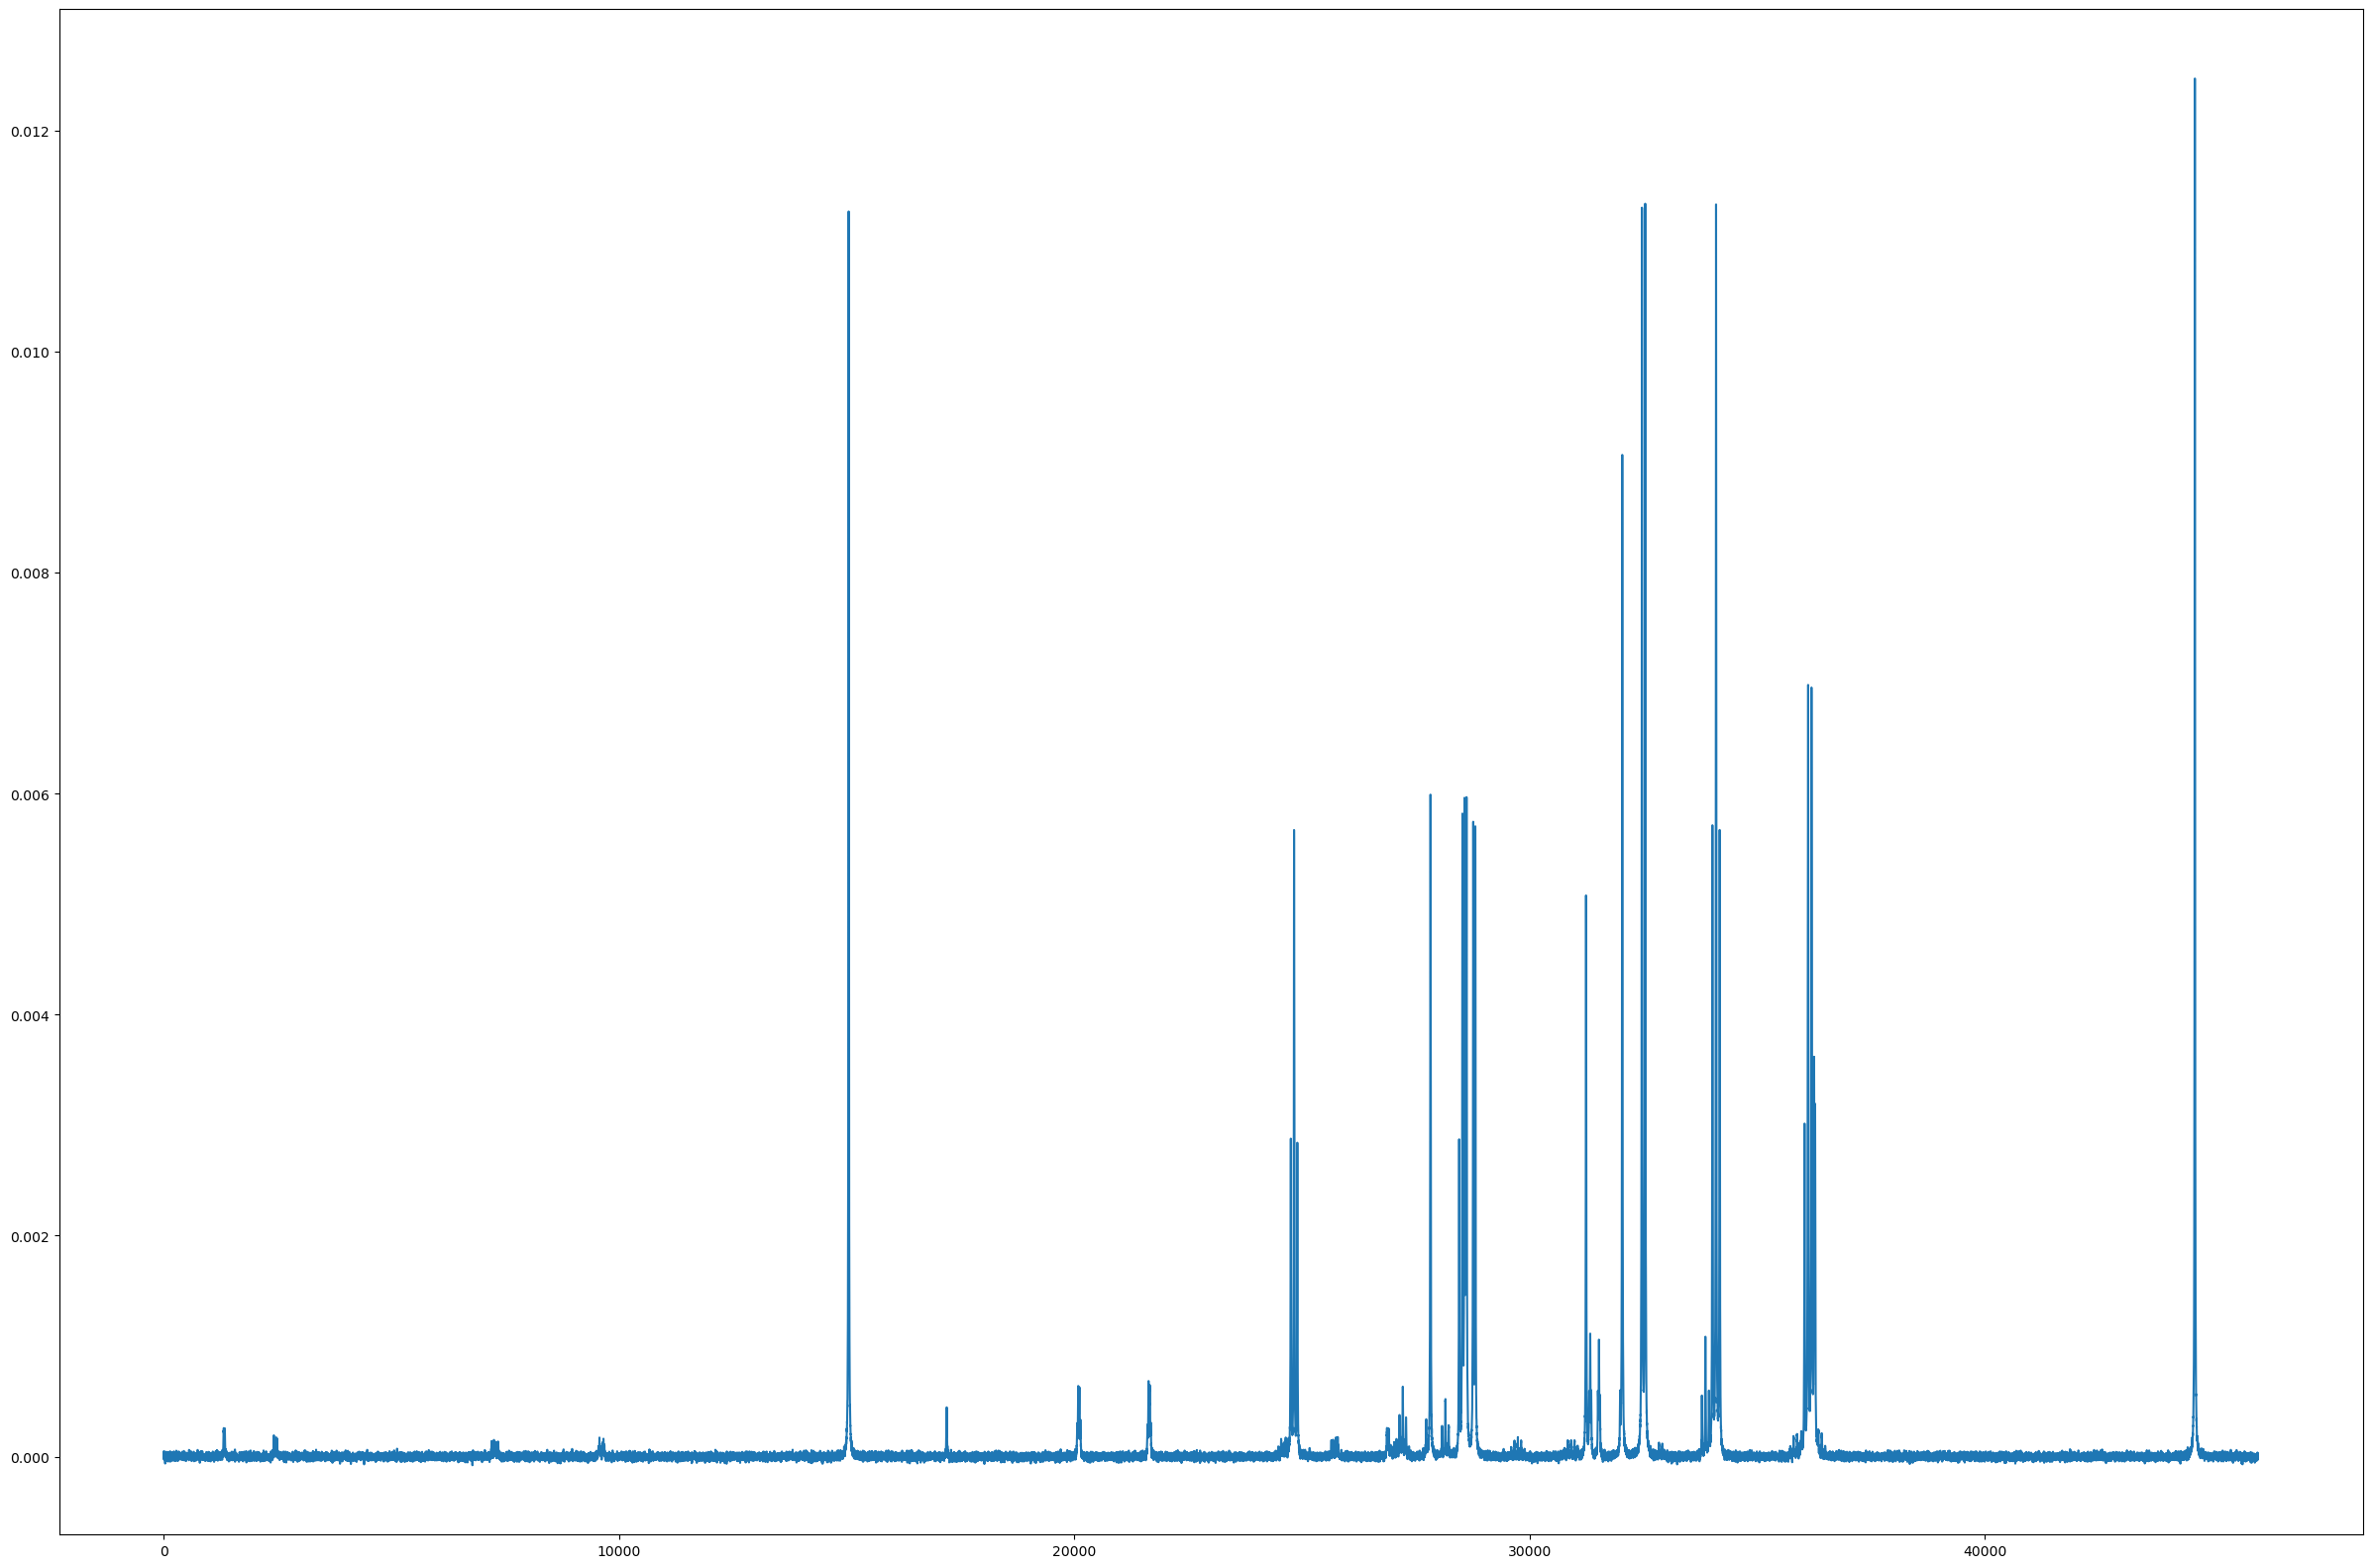

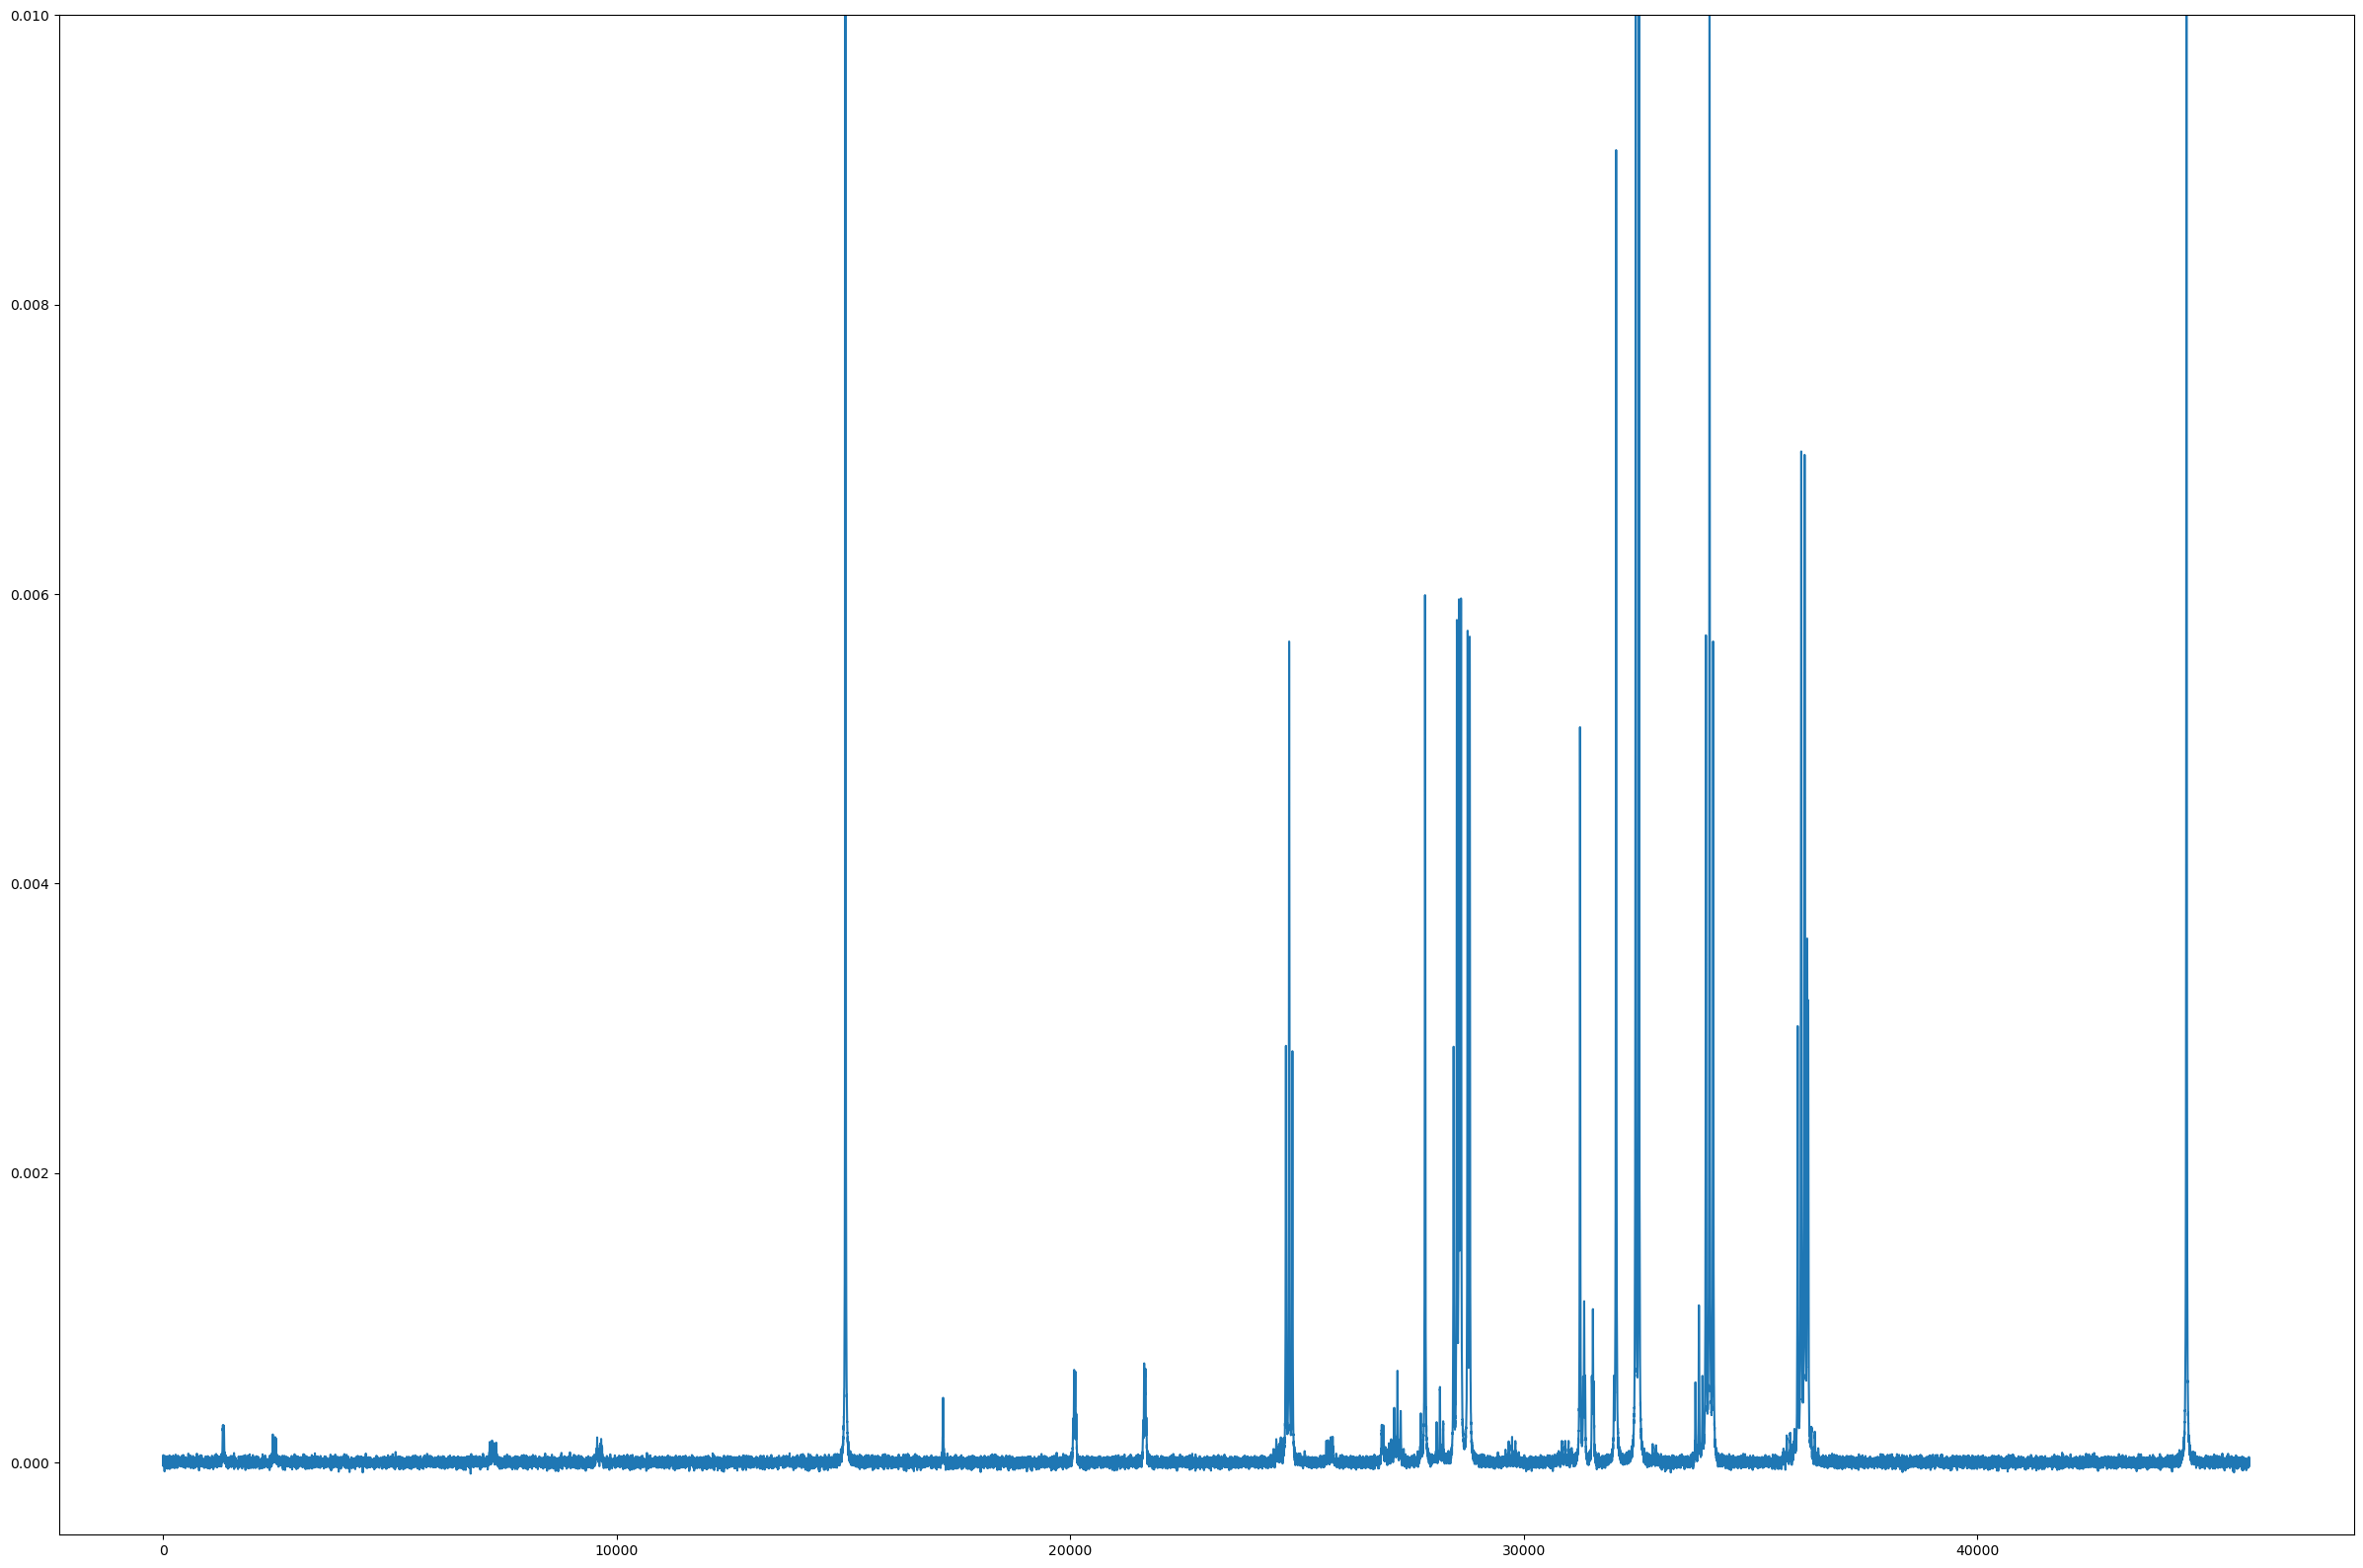

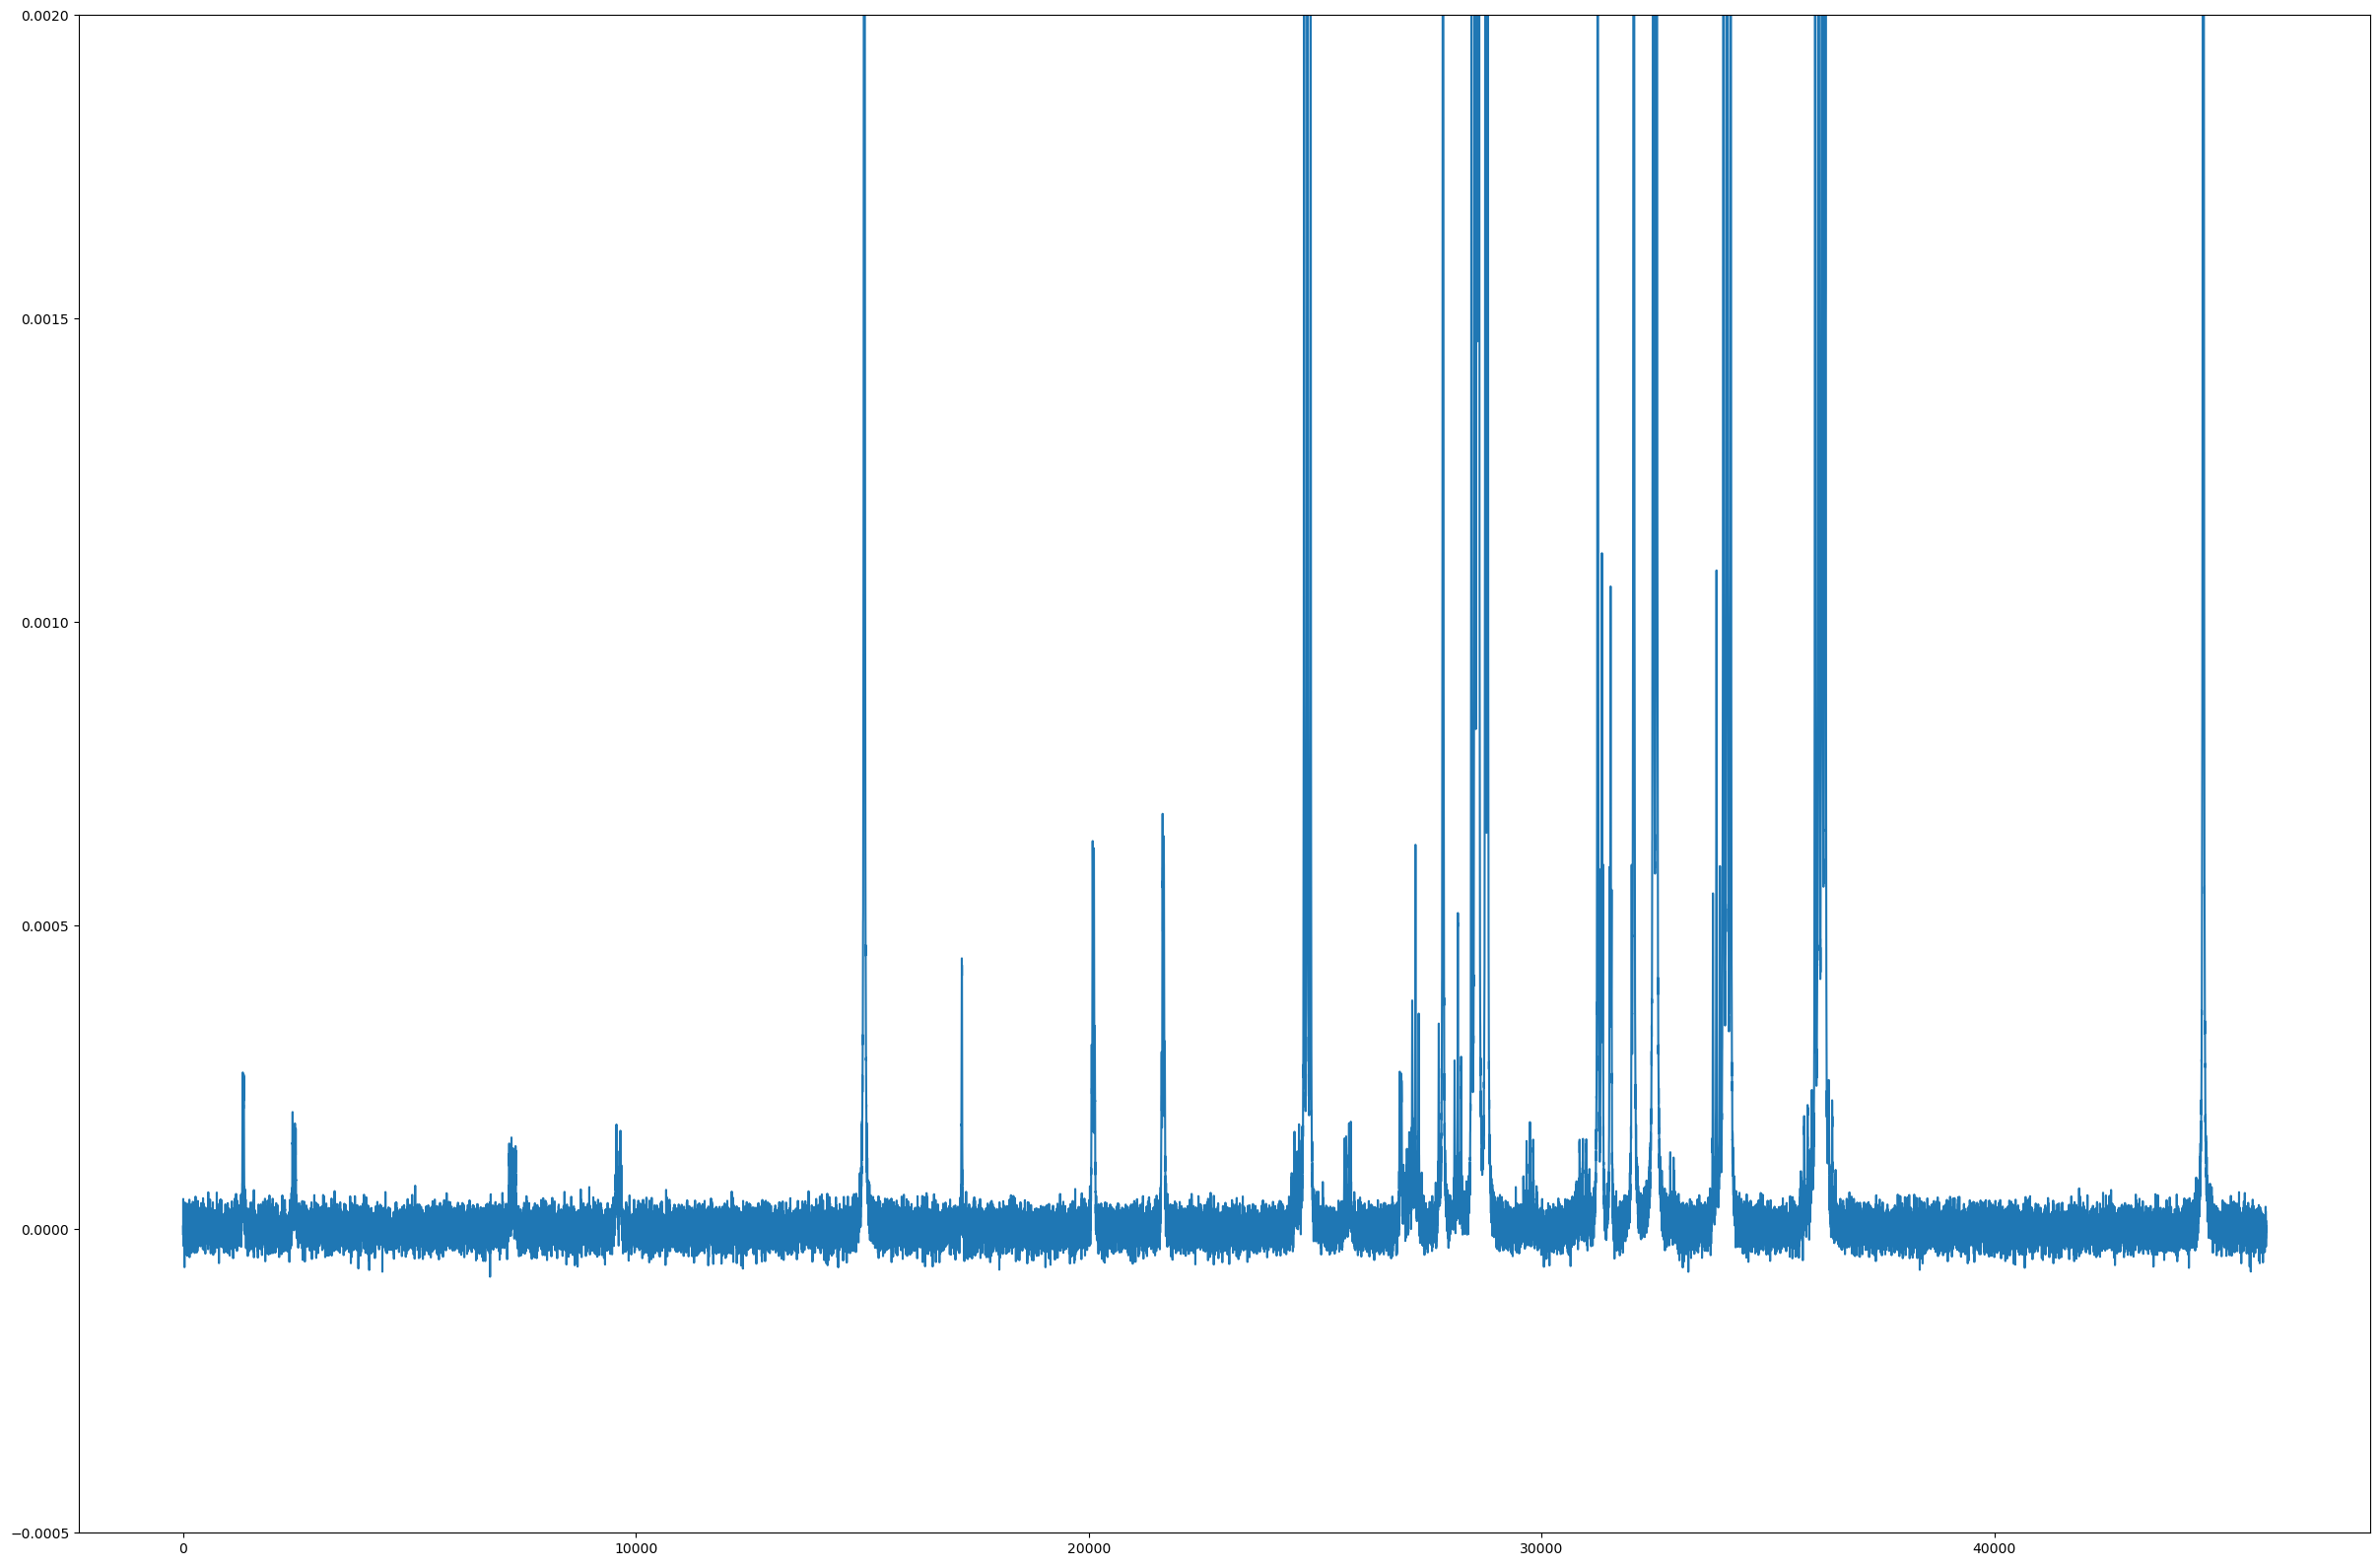

In [28]:
plt.plot(MimicTissueRangeSpec[0][0].detach().cpu().numpy())
plt.show()
plt.plot(MimicTissueRangeSpec[0][0].detach().cpu().numpy())
plt.ylim(-0.0005, 0.01)
plt.show()
plt.plot(MimicTissueRangeSpec[0][0].detach().cpu().numpy())
plt.ylim(-0.0005, 0.002)
plt.show()

In [29]:
## Compute absolute percent error statistics on tissue mimicking distribution validation spectra (high relative glucose concentration)

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = MimicTissueRangeGlucConc[i]
    model_aq.eval()
    Prediction = model_aq(MimicTissueRangeGlucSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(8):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "MimicTissueRangeGlucExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "MimicTissueRangeGlucExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(MimicTissueRangeGlucConc[i].min().item(),4), " - Mean Value:", np.round(MimicTissueRangeGlucConc[i].mean().item(),1))

Overall MAPE:  649.4303
--------------------
1481.9  - Min Value: 0.0323  - Mean Value: 0.7
381.57  - Min Value: 0.0323  - Mean Value: 0.7
973.42  - Min Value: 0.0323  - Mean Value: 0.9
932.08  - Min Value: 0.0323  - Mean Value: 0.6
464.86  - Min Value: 0.0323  - Mean Value: 0.8
749.33  - Min Value: 0.0323  - Mean Value: 1.3
717.78  - Min Value: 0.0323  - Mean Value: 0.9
261.66  - Min Value: 0.0323  - Mean Value: 0.6
262.59  - Min Value: 0.0323  - Mean Value: 0.9
269.1  - Min Value: 0.0324  - Mean Value: 1.1


In [30]:
## Compute absolute percent error statistics on a further high dynamic range dataset

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = HighDynamicRange2Conc[i]
    model_aq.eval()
    Prediction = model_aq(HighDynamicRange2Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(8):
        per_err = 100*(GroundTruth[metabolite] - Prediction_cpu[0][metabolite]) / GroundTruth[metabolite]
        APE.append(abs(per_err.cpu()))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "HighDynamicRange2Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "HighDynamicRange2Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2), " - Min Value:", np.round(HighDynamicRange2Conc[i].min().item(),4), " - Mean Value:", np.round(HighDynamicRange2Conc[i].mean().item(),1))

Overall MAPE:  11.594417
--------------------
10.17  - Min Value: 0.0067  - Mean Value: 2.5
12.22  - Min Value: 0.0095  - Mean Value: 3.6
2.56  - Min Value: 0.0109  - Mean Value: 0.1
25.3  - Min Value: 0.0078  - Mean Value: 8.7
3.54  - Min Value: 0.029  - Mean Value: 6.1
6.7  - Min Value: 0.021  - Mean Value: 8.6
4.96  - Min Value: 0.0473  - Mean Value: 6.9
39.11  - Min Value: 0.0055  - Mean Value: 9.5
10.83  - Min Value: 0.02  - Mean Value: 6.0
0.55  - Min Value: 0.0415  - Mean Value: 5.5


In [31]:
## Compute absolute percent error statistics on a examples of varying SNR

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(SNR_Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(8):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "SNR_Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "SNR_Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x54784 and 47104x8)

In [32]:
## Compute absolute percent error statistics on a dataset with singlets added at random

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(Singlet_Spec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(8):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "SingletExamples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "SingletExamples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

Overall MAPE:  91.74556590096896
--------------------
91.03
91.05
91.07
91.09
91.13
91.13
91.12
91.65
94.08
94.12


In [33]:
## Compute absolute percent error statistics on a examples of varying SNR

APEs = []
MAPEs = []

for i in np.arange(10):
    GroundTruth = 0.43
    model_aq.eval()
    Prediction = model_aq(QrefSensSpec[i])

    # Move Prediction tensor to CPU and detach from computation graph
    Prediction_cpu = Prediction.detach().cpu().numpy()

    APE = []

    for metabolite in range(8):
        per_err = 100*(GroundTruth - Prediction_cpu[0][metabolite]) / GroundTruth
        APE.append(abs(per_err))

    MAPE = sum(APE) / len(APE)

    APEs.append(APE)
    MAPEs.append(MAPE)


# Convert lists to numpy arrays and save
np.save(ModelName + "_" + "QrefSensitivity_Examples_APEs.npy", np.array(APEs))
np.save(ModelName + "_" + "QrefSensitivity_Examples_MAPEs.npy", np.array(MAPEs))



## Output metrics
print('Overall MAPE: ',np.array(MAPEs).mean())
print("--------------------")
for i in np.arange(10):
    print(round(MAPEs[i].item(), 2))

Overall MAPE:  65.76835499599923
--------------------
81.34
65.57
56.99
50.48
52.01
54.84
50.87
64.96
81.65
98.99


In [34]:
Pred = model_aq(OtherValSpectra[0])
Pred[0][Pred[0] < 0] = 0
print("Sinusoidal Baseline 1")
print(Pred[0])
print("___________")
print("___________")

Pred = model_aq(OtherValSpectra[1])
Pred[0][Pred[0] < 0] = 0
print("Sinusoidal Baseline 2")
print(Pred[0])
print("___________")
print("___________")

Pred = model_aq(OtherValSpectra[2])
Pred[0][Pred[0] < 0] = 0
print("HD-Range 1 - 0.01s and 20s")
print(Pred[0])

Pred = model_aq(OtherValSpectra[3])
Pred[0][Pred[0] < 0] = 0
print("HD-Range 2 - 0s and 20s")
print(Pred[0])

Sinusoidal Baseline 1
tensor([0.5940, 1.4787, 0.4756, 1.7891, 0.9474, 0.7894, 0.8086, 0.9580],
       device='cuda:0', grad_fn=<SelectBackward0>)
___________
___________
Sinusoidal Baseline 2
tensor([0.5316, 1.2301, 0.1363, 1.8153, 0.7854, 0.6781, 0.6979, 0.4574],
       device='cuda:0', grad_fn=<SelectBackward0>)
___________
___________
HD-Range 1 - 0.01s and 20s
tensor([ 0.0000, 19.7051,  0.0000, 19.9018,  0.0000, 20.0562,  0.0000, 19.9625],
       device='cuda:0', grad_fn=<SelectBackward0>)
HD-Range 2 - 0s and 20s
tensor([ 0.0000, 19.7105,  0.0000, 19.9051,  0.0000, 20.0559,  0.0000, 19.9648],
       device='cuda:0', grad_fn=<SelectBackward0>)
